In [38]:
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1, 0],  # activities
    [1, 1, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=3,
    n_generate=100,
    endo_or_exo_probability=[0.5, 0.5],
    enzymes=enzymes,
)

 99 / 100 (120)
75 unique peptides. 103 total


 0 / 5000 | 1.20, mean: nan | Plateau | nz: 0

 21 / 5000 | 0.71, mean: 0.81 | Decreasing | nz: 591

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 4999 / 5000 | 0.11, mean: 0.11 | Plateau | nz: 4353

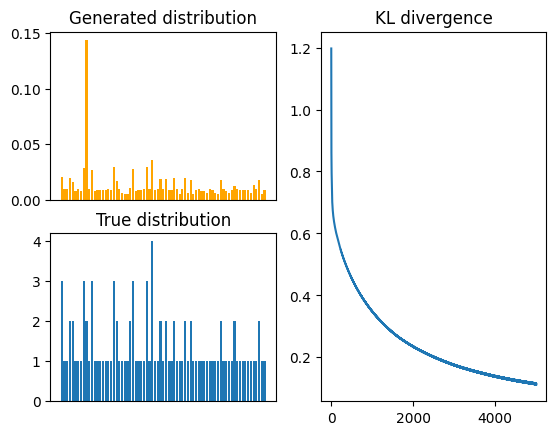

In [39]:
from disassembly.estimate_weights_gd import estimate_weights


G, kls, generated, weights = estimate_weights(
    true_dict=P,
    lr=0.001,
    n_iterations=5000,

)

fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)


axs["true"].bar(P.keys(), P.values())
axs["generated"].bar(
    generated[len(generated.keys()) -1 ].keys(),
    generated[len(generated.keys())-1].values(),
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [40]:
from disassembly.disassembly import get_disassembly_indexes
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes(sequence_graph)
get_disassembly(P, real_disassembly_indexes)

 74 / 75 | checking 2 paths
 Averaged DI: 2.44


2.4563106796116507

In [41]:
from disassembly.disassembly import get_disassembly_indexes_mc

mc_di = get_disassembly_indexes_mc(G, 20000)
get_disassembly(P, mc_di)


 Averaged DI: 2.59


2.625423152312739

Text(0.5, 0.98, 'Disassembly indexes')

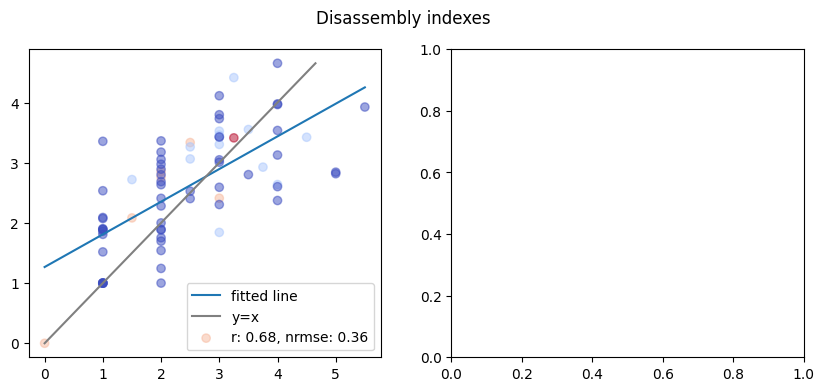

In [42]:
from scipy.stats import linregress
import numpy as np

# fig, axs = plt.subplots(1,3, figsize=(12,4))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
trues = []
ys_mc = []
c = []


def get_nrmse(true, observed):
    true = np.array(true)
    observed = np.array(observed)
    rmse = np.sqrt(np.mean((true - observed)**2))
    nrmse = rmse / np.mean(true)
    return nrmse           

for key in P.keys():
    if str(np.mean(mc_di[key])) == "nan":
        print(key)
        continue
    trues.append((real_disassembly_indexes[key]))

    ys_mc.append(mc_di[key])
    c.append(P[key])
a = 0

for xs, ys in [(trues, ys_mc)]:
    regress = linregress(xs, ys)
    nrmse = get_nrmse(xs, ys)
    axs[a].plot(
        np.linspace(0, max(xs)),
        regress.intercept + np.linspace(0, max(xs)) * regress.slope,
        label="fitted line",
    )
    axs[a].plot(
        np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x"
    )
    axs[a].scatter(
        xs, ys, label=f"r: {regress.rvalue:.2f}, nrmse: {nrmse:.2f}", c=c, cmap="coolwarm", alpha=0.5
    )
    axs[a].legend()
    a += 1

plt.suptitle("Disassembly indexes")

In [43]:
import networkx as nx
import pandas as pd

aG = pd.DataFrame(
    nx.adjacency_matrix(G, nodelist=G.nodes()).toarray().T,
    index=G.nodes(),
    columns=G.nodes(),
).sort_index(key=lambda x: x.str.len())
aG = aG[aG.index]
pG = pd.DataFrame(
    nx.adjacency_matrix(sequence_graph, nodelist=G.nodes()).toarray().T,
    index=sequence_graph.nodes(),
    columns=sequence_graph.nodes(),
).sort_index(key=lambda x: x.str.len())
pG = pG[pG.index]

74.0 33.332756337957264 95.56065509120829


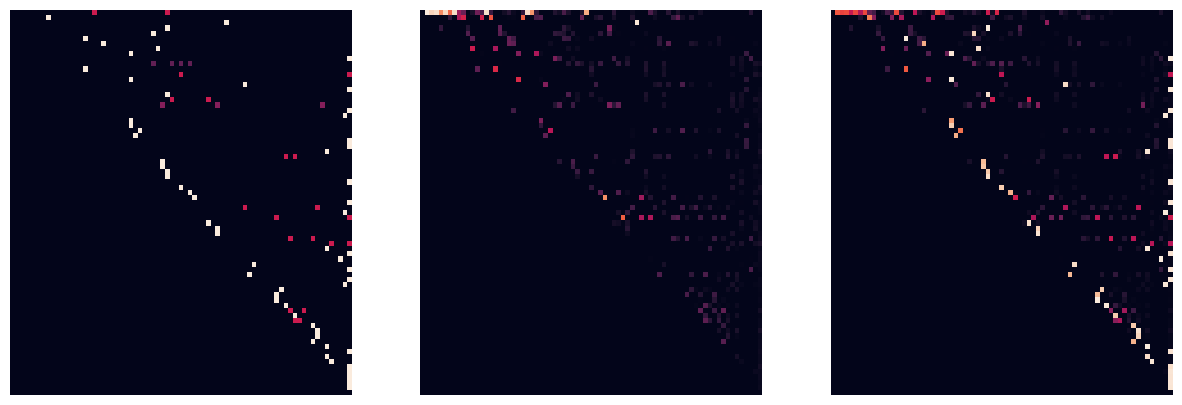

In [44]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(pG, ax=axs[0], cbar=None)
sns.heatmap(aG, ax=axs[1], cbar=None)
sns.heatmap(np.abs(pG - aG), ax=axs[2], cbar=None)

print(sum(sum(pG.values)), sum(sum(aG.values)), sum(sum(np.abs(pG - aG).values)))

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])